# SUMMARY

원본: https://github.com/khuda-data/5th-MLteam2-Recommend-Travel-Route/tree/main

1. 데이터프레임 전처리(원본 ipynb파일에 없는 걸 보아 따로 전처리한 것으로 보임)
   - **위도, 경도** 값이 없는 일부 데이터들의 값들을 채움
   - '올레길', '올레길 주차장' 처럼 **달리 표기된 장소를 하나로** 통일
   - 방문지에서 **사적 장소**(집, 친구/친지집, 사무실), **기타**(편의점, 피시방, 사우나 등)은 데이터에서 배제
      - codeB를 이용해서 完
      - 논의해야 할 점
      - 기타를 포함할지?
        - 역, 터미널, 고속도로 휴게소를 포함할지?(선행 제주도 프로젝트에서는 포함한 것으로 보임)
   - **식당**이면 RES, **관광지**면 TOU로 데이터 구분
     - codeB를 이용해서 code 10(식당)이 아니면 TOU로 넣으면 될 것 같음
     - but, 다른 code Num을 갖는 것들 중 예외 처리 필요 있음(상업지구, 상점, 지역축제 등)
2. 데이터프레임 병합
   - 여행객 Mster
   - 여행
   - 방문지 정보
3. 차량 여부를 입력 받음
4. TRAVEL_STYL_{n}(1 $\leq$ n $\leq$ 7)을 사용자로부터 입력을 받고, 3에서 필터링한 유저 중 MSE를 기준으로 유사한 사용자를 추출
   - **원본에는 클러스터 내 여행객에서 차이를 구한다고 주석이 달려있지만, 코드는 그렇지 않음.**
   - 그래서, 임의로 방문지의 locations으로 클러스터를 할당해 진행하려고 했으나, NaN값을 처리할 수가 없음(모델은 숙박 지점에 대해서만 학습).
5. 4에서 구한 유사도 상위 5명에 대해서 총 만족도(만족도 + 재방문의향 + 추천도)를 추가 후 만족도 기준 가장 높은 어트랙션 4개씩 추천(총 5 x 4 = 20)
6. locations 기준으로 방문 순서를 구한 후 숙소부터 시작해서 방문 순서를 추천 후 상위 4개만 남김
7. 1번과 3번 어트랙션을 기준으로 가장 가까운 음식점 추천(각각 점심, 저녁)

# 개선점
  
- 라벨링 구체화 필요
  - 식당 + 카페를 하나로 묶어 '맛집'으로 라벨링 함 $\rightarrow$ 식당과 카페를 분리해 라벨링을 해야 함.
- 직선거리와 실제 이동거리의 차이점
  - 직선거리는 실제거리와 다름 $\rightarrow$ 실제 이동거리를 계산할 수 있는 알고리즘으로 바꿔야 함
- K-Means 클러스터링 모델 문제
  - 클러스터의 경계에서 본인과 유사한 여행 스타일을 가진 여행객들의 여행 경로가 멀어질 수 있음 $\rightarrow$ 지형 분석에 유리한 DBSCAN 모델 도입
- 여행객 유사도 분석 보완
  - 코사인 유사도는 방향의 유사성을 판단하기 때문에 특정 샘플에 대해서 부정확한 유사도를 보임
  - MSE는 길이의 유사성을 판단하기 때문에 유사도가 이산적이고 동일성을 보임
  - $\rightarrow$ 규제항을 도입해서 코사인 유사도와 MSE를 같은 비율로 볼 수 있는 람다를 찾는다.

# 차별점

- 자신의 숙소와 여행지 간의 거리 최소화 $\leftarrow$ 잘 모르겠음.
- 자동차 유무를 통한 여행지 간 거리 고려 $\leftarrow$ 다른 조건(숙박, 지출구간 등)으로 해도 괜찮을 것으로 보임
- 여행 선호도를 통한 맞춤형 여행지 추천 $\leftarrow$ 단순히 'TRAVEL_STYL_{n}'에 대해서만 구해서 다른 방식도 추가 적용한다면 괜찮을 것으로 보임
- 여행 '경로'를 추천하여 효율적인 여행 $\leftarrow$ 괜찮은 듯

# Import Library

In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.colors as mcolors
from matplotlib import cm
from plotly import graph_objects as go
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
import os
import re
from joblib import Parallel, delayed
from typing import Tuple, List, Union
from tqdm import tqdm

from util.data_processing import *
from util.modeling import *
from util.utils import *
from util.viz import *

# 경고 메시지 무시 설정
warnings.filterwarnings('ignore')

# Pandas 설정
pd.set_option('display.max_columns', None)

%reload_ext autotime

time: 0 ns (started: 2024-08-01 20:12:47 +09:00)


In [2]:
op_env = 'windows'
base_dir = ''

if op_env == 'windows':
    base_dir = './data/total/'
elif op_env == 'mac':
    base_dir = './total/'

time: 0 ns (started: 2024-08-01 20:12:47 +09:00)


In [3]:
# 0. 데이터 전처리
# 여행객 데이터와 방문지 정보를 불러오기
traveler_master = pd.read_csv(os.path.join(base_dir, '여행객 Master.csv'))
traveler_master['계절'] = traveler_master['TRAVEL_STATUS_YMD'].apply(lambda x: pd.to_datetime(x.split('~')[0])).apply(get_season)

visit_info = pd.read_csv(os.path.join(base_dir, '방문지정보.csv'), dtype={'X_COORD': str, 'Y_COORD': str})
visit_info['계절'] = pd.to_datetime(visit_info['VISIT_START_YMD']).apply(get_season)
travel = pd.read_csv(os.path.join(base_dir, '여행.csv'))            

time: 2.86 s (started: 2024-08-01 20:12:47 +09:00)


In [4]:
visit_pre = pd.read_csv(os.path.join(base_dir, '방문지정보.csv'))
visit_pre['TRAVELER_ID'] = visit_pre['TRAVEL_ID'].str.split('_').apply(lambda x: x[1])

# 12: 기타, 21: 집, 22: 친구/친지집, 23: 사무실
del_area_type = {12, 21, 22, 23}

# 사적 장소 제거
visit_pre = visit_pre[~visit_pre['VISIT_AREA_TYPE_CD'].isin(del_area_type)]
# 식당, 관광지 구분
visit_pre['VISIT_AREA_TYPE_CD'] = visit_pre['VISIT_AREA_TYPE_CD'].apply(lambda x: 'RES' if x == 10 else 'TOU')

# 여행 데이터와 방문지 정보를 여행ID(TRAVEL_ID)를 기준으로 합치기
visit_data = pd.merge(travel, visit_info, on='TRAVEL_ID')
# 위 데이터를 여행객 마스터와 합치기 (TRAVEL_ID)를 기준으로
visit_final = pd.merge(visit_data, traveler_master, on='TRAVELER_ID')

travel_pre = pd.merge(travel, traveler_master, on='TRAVELER_ID', how='inner')

time: 453 ms (started: 2024-08-01 20:12:50 +09:00)


In [5]:
travel_pre

,TRAVEL_ID,TRAVEL_NM,TRAVELER_ID,TRAVEL_PURPOSE,TRAVEL_START_YMD,TRAVEL_END_YMD,MVMN_NM,TRAVEL_PERSONA,TRAVEL_MISSION,TRAVEL_MISSION_CHECK,region_x,RESIDENCE_SGG_CD,GENDER,AGE_GRP,EDU_NM,EDU_FNSH_SE,MARR_STTS,FAMILY_MEMB,JOB_NM,JOB_ETC,INCOME,HOUSE_INCOME,TRAVEL_TERM,TRAVEL_NUM,TRAVEL_LIKE_SIDO_1,TRAVEL_LIKE_SGG_1,TRAVEL_LIKE_SIDO_2,TRAVEL_LIKE_SGG_2,TRAVEL_LIKE_SIDO_3,TRAVEL_LIKE_SGG_3,TRAVEL_STYL_1,TRAVEL_STYL_2,TRAVEL_STYL_3,TRAVEL_STYL_4,TRAVEL_STYL_5,TRAVEL_STYL_6,TRAVEL_STYL_7,TRAVEL_STYL_8,TRAVEL_STATUS_RESIDENCE,TRAVEL_STATUS_DESTINATION,TRAVEL_STATUS_ACCOMPANY,TRAVEL_STATUS_YMD,TRAVEL_MOTIVE_1,TRAVEL_MOTIVE_2,TRAVEL_MOTIVE_3,TRAVEL_COMPANIONS_NUM,region_y,계절
0,e_e000004,E03,e000004,3,2023-04-30,2023-05-01,NaN,서울 외 수도권 방문/수도권 거주/40세 이상/자녀동반/일반미션,3,3;4;11,capital,41,남,40,6,1.0,2,3,2,NaN,7,8.0,2,1,50,50110,42,42210,42,42170,5,3,5,4,5,4,2,5,경기도,경기,자녀 동반 여행,2023-04-29~2023-04-30,1,3.0,NaN,2,capital,봄
1,e_e000006,E03,e000006,21,2023-04-30,2023-05-02,NaN,경기 방문/거주지 구분 없음/39세 이하/특별미션,21,21;10;27,capital,11,남,30,7,1.0,1,1,3,NaN,5,NaN,3,4,26,26350,26,26710,50,50110,3,3,2,4,5,4,3,2,서울특별시,경기,2인 가족 여행,2023-04-30~2023-05-01,1,2.0,3.0,1,capital,봄
2,e_e000009,E03,e000009,2;4,2023-04-29,2023-05-01,NaN,서울 외 수도권 방문/수도권 거주/39세 이하/커플/일반미션,2;4,22;1;7,capital,28,여,30,5,1.0,1,3,3,NaN,4,12.0,2,1,42,42150,11,11440,41,41650,3,2,3,3,2,6,4,7,인천광역시,경기,2인 여행(가족 외),2023-04-29~2023-04-30,3,1.0,2.0,1,capital,봄
3,e_e000010,E01,e000010,3;6,2023-04-29,2023-05-01,NaN,서울 방문/수도권 외 거주/39세 이하/나홀로 여행/일반미션,3;6,6;3;1,capital,48,여,30,6,1.0,1,2,3,NaN,4,4.0,2,2,11,11710,11,11440,26,26350,5,4,3,2,5,4,5,3,경상남도,서울,나홀로 여행,2023-04-29~2023-04-30,8,1.0,2.0,0,capital,봄
4,e_e000011,E01,e000011,1;21,2023-04-28,2023-05-01,NaN,서울 방문/수도권 외 거주/40세 이상/커플/일반미션,1;21,6;2;24,capital,48,여,60,7,1.0,2,1,2,NaN,7,NaN,2,1,48,48220,11,11560,26,26710,3,3,3,4,2,4,6,6,경상남도,서울,3인 이상 여행(가족 외),2023-04-28~2023-04-30,3,7.0,1.0,3,capital,봄
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,g_g013127,G06,g013127,1;10;2;23,2023-09-27,2023-09-28,NaN,충청권 방문/충청권 거주/39세 이하/나홀로 여행/일반미션,1;10;2;23,1;2;3,western,43,여,30,6,1.0,1,1,3,NaN,4,NaN,3,5,42,42210,11,11680,44,44270,2,2,1,4,2,4,3,3,충청북도,충남,나홀로 여행,2023-09-27~2023-09-27,7,2.0,6.0,0,western,가을
7676,g_g013128,G04,g013128,21;22;24;3;6,2023-09-29,2023-09-30,NaN,전남 방문/거주지 구분 없음/39세 이하/특별미션,21;22;24;3;6,6;1;21,western,29,여,20,6,2.0,1,1,12,NaN,1,NaN,3,3,50,50110,11,11680,30,30170,4,6,5,3,4,3,7,5,광주광역시,대전,나홀로 여행,2023-09-29~2023-09-29,1,2.0,8.0,0,western,가을
7677,g_g013131,G03,g013131,2;21;22;26;4,2023-09-29,2023-09-30,NaN,전남 방문/거주지 구분 없음/39세 이하/특별미션,2;21;22;26;4,4;22;21,western,29,남,20,6,1.0,1,2,13,NaN,1,8.0,2,1,11,11440,26,26500,50,50130,6,3,2,3,3,6,6,6,광주광역시,전남,2인 여행(가족 외),2023-09-29~2023-09-29,5,3.0,2.0,1,western,가을
7678,h_h001459,G05,h001459,22,2023-07-06,2023-07-08,대중교통 등,충북 방문/거주지 구분 없음/39세 이하/특별미션,22,22;5;26,western,11,남,30,7,2.0,1,3,12,NaN,4,12.0,2,1,50,50130,26,26350,11,11680,4,2,2,3,2,5,1,7,서울특별시,제주,2인 가족 여행,2023-07-07~2023-07-09,7,3.0,NaN,1,western,여름


time: 47 ms (started: 2024-08-01 20:12:50 +09:00)


In [6]:
visit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79165 entries, 0 to 79164
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TRAVEL_ID             79165 non-null  object 
 1   TRAVEL_NM             79165 non-null  object 
 2   TRAVELER_ID           79165 non-null  object 
 3   TRAVEL_PURPOSE        79165 non-null  object 
 4   TRAVEL_START_YMD      79165 non-null  object 
 5   TRAVEL_END_YMD        79165 non-null  object 
 6   MVMN_NM               72737 non-null  object 
 7   TRAVEL_PERSONA        79165 non-null  object 
 8   TRAVEL_MISSION        79165 non-null  object 
 9   TRAVEL_MISSION_CHECK  79165 non-null  object 
 10  region_x              79165 non-null  object 
 11  VISIT_AREA_ID         79165 non-null  int64  
 12  VISIT_ORDER           79165 non-null  int64  
 13  VISIT_AREA_NM         79165 non-null  object 
 14  VISIT_START_YMD       79165 non-null  object 
 15  VISIT_END_YMD      

In [7]:
visit_final = visit_info.copy()

print(visit_final[~visit_final['X_COORD'].apply(is_numeric)]['X_COORD'].unique())
print(visit_final[~visit_final['Y_COORD'].apply(is_numeric)]['Y_COORD'].unique())

[nan]
[nan]
time: 156 ms (started: 2024-08-01 20:12:51 +09:00)


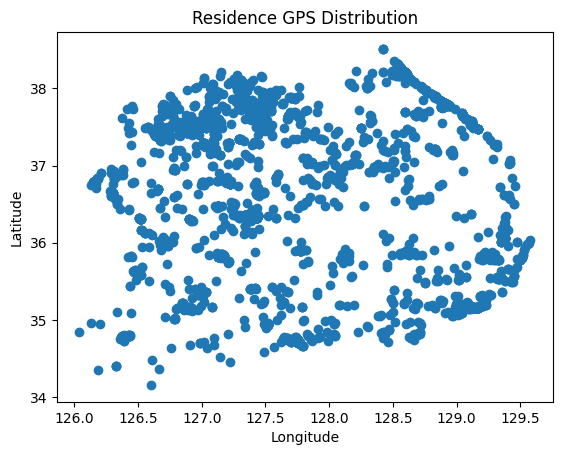

time: 172 ms (started: 2024-08-01 20:12:51 +09:00)


In [8]:
# VISIT_AREA_TYPE_CD가 24인 행 필터링
visit_final_lodging = visit_final[visit_final['VISIT_AREA_TYPE_CD'] == 24]

# VISIT_AREA_TYPE_CD가 21 또는 22인 행 필터링하여 추가
rows_with_home = visit_final[visit_final['VISIT_AREA_TYPE_CD'].isin([21, 22])]
visit_final_lodging = pd.concat([visit_final_lodging, rows_with_home], ignore_index=True)

# 여행 ID가 중복되는 행 제거
visit_final_lodging = visit_final_lodging.drop_duplicates(subset=['TRAVEL_ID'])

# X_COORD와 Y_COORD를 float 타입으로 변환
visit_final_lodging['X_COORD'] = visit_final_lodging['X_COORD'].astype(float)
visit_final_lodging['Y_COORD'] = visit_final_lodging['Y_COORD'].astype(float)

# 대한민국 경계 좌표
kor_boundary = {'min_lon': 124.5, 'max_lon': 132.0, 'min_lat': 33.0, 'max_lat': 38.9}

# 경계 좌표 내에 있는 데이터만 선택
filtered_data = visit_final_lodging[
    (visit_final_lodging['X_COORD'].between(kor_boundary['min_lon'], kor_boundary['max_lon'])) &
    (visit_final_lodging['Y_COORD'].between(kor_boundary['min_lat'], kor_boundary['max_lat']))
]

# 데이터프레임에서 경도와 위도 추출
longitude = filtered_data['X_COORD']
latitude = filtered_data['Y_COORD']

# 시각화
plt.scatter(longitude, latitude)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Residence GPS Distribution')
plt.show()

In [9]:
# 지도 생성
m = folium.Map(location=[36.5, 127.5], zoom_start=7)

# 데이터 추가
for idx, row in filtered_data.iterrows():
    folium.Marker([row['Y_COORD'], row['X_COORD']]).add_to(m)

# 지도 표시
m.save('residence_gps_distribution.html')
m

time: 1.73 s (started: 2024-08-01 20:12:51 +09:00)


In [10]:
# Plotly Express로 시각화
fig = px.scatter_mapbox(
    filtered_data,
    lat='Y_COORD',
    lon='X_COORD',
    zoom=5,
    mapbox_style="carto-positron",
    title='Residence GPS Distribution'
)

fig.show()

time: 1.44 s (started: 2024-08-01 20:12:53 +09:00)


In [11]:
locations, cluster_centers, labels = generate_kmeans_clusters(longitude, latitude, 5)

time: 203 ms (started: 2024-08-01 20:12:54 +09:00)


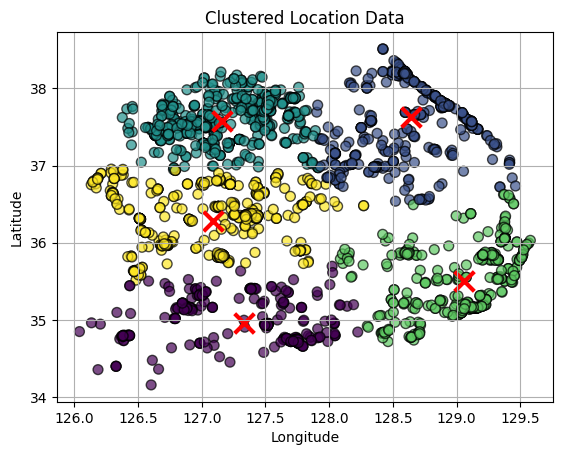

time: 172 ms (started: 2024-08-01 20:12:54 +09:00)


In [12]:
# 클러스터링 결과 시각화
plt.scatter(locations[:, 0], locations[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.7)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', c='red', s=200, linewidths=3)
plt.title('Clustered Location Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [13]:
visualize_with_folium(locations, cluster_centers, labels)

time: 1.88 s (started: 2024-08-01 20:12:55 +09:00)


In [14]:
visualize_with_plotly(locations, cluster_centers, labels)

time: 78 ms (started: 2024-08-01 20:12:56 +09:00)


100%|██████████| 28/28 [00:00<00:00, 143.64it/s]


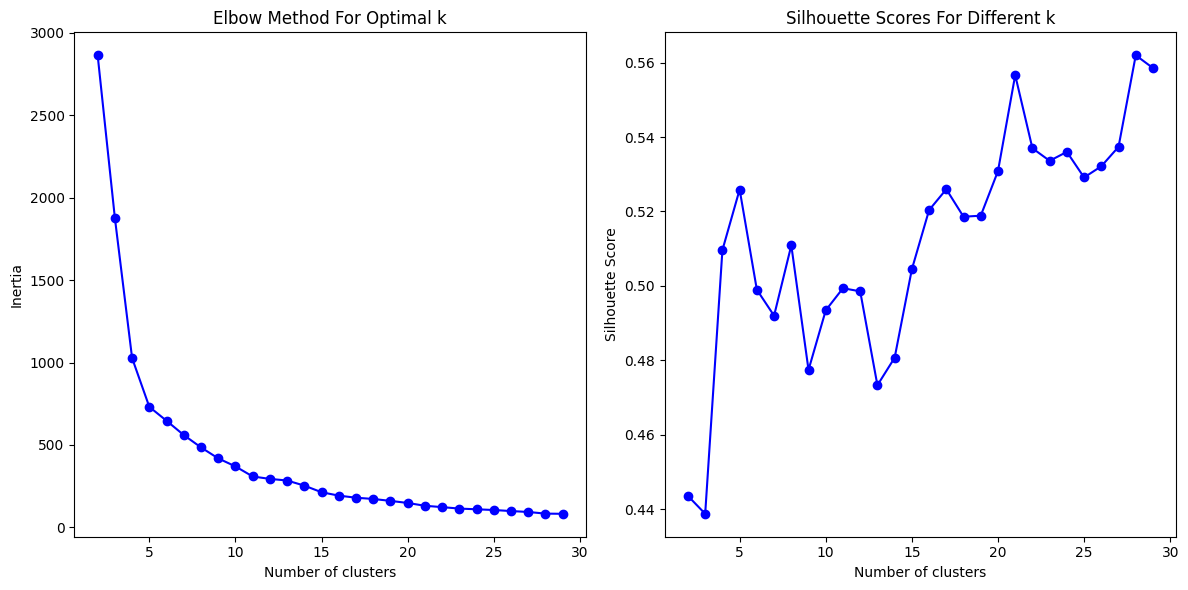

time: 6.41 s (started: 2024-08-01 20:12:57 +09:00)


In [15]:
# Range of k values
K = range(2, 30)

# Compute inertia and silhouette scores in parallel
results = Parallel(n_jobs=-1)(delayed(compute_kmeans)(k, locations) for k in tqdm(K))

# Separate the results into inertia and silhouette scores
inertia, silhouette_scores = zip(*results)

# Plotting the Elbow Method
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

# Plotting the Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For Different k')

plt.tight_layout()
plt.show()

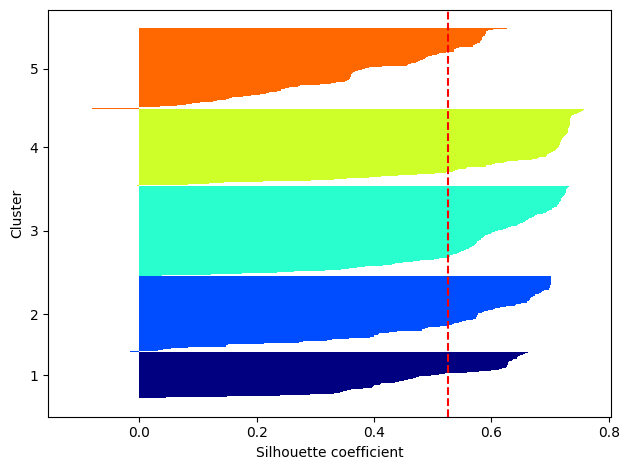

time: 2.03 s (started: 2024-08-01 20:13:03 +09:00)


In [16]:
plot_silhouette(locations)

In [17]:
km = KMeans(n_clusters=5, random_state=42)
km.fit(locations)

# 숙소의 위치와 클러스터 중심 좌표 입력 받기
acc_lat = float(input("숙소의 위도를 입력하세요: "))
acc_lng = float(input("숙소의 경도를 입력하세요: "))

# 클러스터 인덱스 찾기
cluster_idx = find_cluster_idx(acc_lat, acc_lng, km.cluster_centers_)
print(f"숙소는 클러스터 {cluster_idx}에 속합니다.")

숙소는 클러스터 3에 속합니다.
time: 5.31 s (started: 2024-08-01 20:13:05 +09:00)


In [18]:
style_mapping = [
    "(자연 vs 도심)", 
    "(숙박 vs 당일)", 
    "(새로운 지역 vs 익숙한 지역)", 
    "(휴양/휴식 vs 체험활동)", 
    "(잘 알려지지 않은 방문지 vs 알려진 방문지)", 
    "(계획에 따른 여행 vs 상황에 따른 여행)", 
    "(사진촬영 중요하지 않음 vs 사진 촬영 중요)"
]

user_travel_style = get_user_travel_style(style_mapping)
print(f"사용자의 여행 스타일: {user_travel_style}")

사용자의 여행 스타일: [7, 1, 7, 1, 2, 1, 7]
time: 5.33 s (started: 2024-08-01 20:13:10 +09:00)


In [19]:
vehicle_usage = input("차량 보유 여부를 입력하세요 (Y/N): ").strip().upper()
while vehicle_usage not in ['Y', 'N']:
    print("유효하지 않은 입력입니다. 'Y' 또는 'N'을 입력하세요.")
    vehicle_usage = input("차량 보유 여부를 입력하세요 (Y/N): ").strip().upper()
    
# 유사한 여행객 계산
similar_users = calculate_similarity(travel_pre, user_travel_style, vehicle_usage)
top_similar_customers = sorted(similar_users, key=lambda x: x[1])[:10]

# 결과 출력
print("내 인근 숙소를 잡은 여행객 중 비슷한 여행 스타일을 가진 상위 10명의 여행객:")
for idx, (travel_id, similarity) in enumerate(top_similar_customers, start=1):
    print(f"번호: {idx}, 여행객 ID: {travel_id}, 유사도: {1 / (1 + similarity):.4f}")

내 인근 숙소를 잡은 여행객 중 비슷한 여행 스타일을 가진 상위 10명의 여행객:
번호: 1, 여행객 ID: f005333, 유사도: 0.8750
번호: 2, 여행객 ID: g000788, 유사도: 0.3684
번호: 3, 여행객 ID: g001740, 유사도: 0.3333
번호: 4, 여행객 ID: e005899, 유사도: 0.2917
번호: 5, 여행객 ID: f010348, 유사도: 0.2800
번호: 6, 여행객 ID: f003400, 유사도: 0.2692
번호: 7, 여행객 ID: f005279, 유사도: 0.2692
번호: 8, 여행객 ID: f001932, 유사도: 0.2593
번호: 9, 여행객 ID: f002638, 유사도: 0.2593
번호: 10, 여행객 ID: f004698, 유사도: 0.2414
time: 2.66 s (started: 2024-08-01 20:13:16 +09:00)


In [20]:
# 상위 10명의 여행객 ID 가져오기
top_travelers_ids = [traveler_id for traveler_id, _ in top_similar_customers[:5]]

# 상위 5명의 여행객의 어트랙션 방문 기록 가져오기 및 'TOU' 유형 필터링
visit_pre_top_5 = visit_pre[(visit_pre['TRAVELER_ID'].isin(top_travelers_ids)) & (visit_pre['VISIT_AREA_TYPE_CD'] == 'TOU')]

# 어트랙션의 만족도를 계산하여 새로운 열 추가 (만족도 + 재방문의향 + 추천의향)
visit_pre_top_5['total_satisfaction'] = visit_pre_top_5[['DGSTFN', 'REVISIT_INTENTION', 'RCMDTN_INTENTION']].sum(axis=1)

# 만족도를 기준으로 내림차순 정렬
visit_pre_top_5_sorted = visit_pre_top_5.sort_values(by=['TRAVELER_ID', 'total_satisfaction'], ascending=[True, False])

# 상위 5명의 만족도가 가장 높은 어트랙션 출력
print("상위 5명의 만족도가 가장 높은 어트랙션:")
for i, traveler_id in enumerate(top_travelers_ids, start=1):
    top_attractions = visit_pre_top_5_sorted[visit_pre_top_5_sorted['TRAVELER_ID'] == traveler_id].head(4)
    print(f"여행객 {i}: {traveler_id}")
    
    if top_attractions.empty:
        print("    - 추천된 어트랙션 개수가 없습니다")
    else:
        for j, row in top_attractions.reset_index(drop=True).iterrows():
            print(f"    - 추천된 어트랙션 {j+1}: {row['VISIT_AREA_NM']} / 만족도: {row['total_satisfaction']}")
            print(f"      - DGSTFN: {row['DGSTFN']}, REVISIT_INTENTION: {row['REVISIT_INTENTION']}, RCMDTN_INTENTION: {row['RCMDTN_INTENTION']}")
        
        # 만약 추천된 어트랙션이 4개 미만이면 나머지 어트랙션은 값이 없는 것으로 처리
        for k in range(len(top_attractions), 4):
            print(f"    - 추천된 어트랙션 {k+1}: 추천된 어트랙션이 적습니다")


상위 5명의 만족도가 가장 높은 어트랙션:
여행객 1: f005333
    - 추천된 어트랙션 1: 하회 세계 탈 박물관 / 만족도: 12.0
      - DGSTFN: 4.0, REVISIT_INTENTION: 4.0, RCMDTN_INTENTION: 4.0
    - 추천된 어트랙션 2: 안동 하회마을 / 만족도: 12.0
      - DGSTFN: 4.0, REVISIT_INTENTION: 4.0, RCMDTN_INTENTION: 4.0
    - 추천된 어트랙션 3: 나드리김밥 경북도청점 / 만족도: 12.0
      - DGSTFN: 4.0, REVISIT_INTENTION: 4.0, RCMDTN_INTENTION: 4.0
    - 추천된 어트랙션 4: 추천된 어트랙션이 적습니다
여행객 2: g000788
    - 추천된 어트랙션 1: 라마다플라자호텔 자은도 / 만족도: 15.0
      - DGSTFN: 5.0, REVISIT_INTENTION: 5.0, RCMDTN_INTENTION: 5.0
    - 추천된 어트랙션 2: 정읍 허브원 / 만족도: 15.0
      - DGSTFN: 5.0, REVISIT_INTENTION: 5.0, RCMDTN_INTENTION: 5.0
    - 추천된 어트랙션 3: 양자강 / 만족도: 15.0
      - DGSTFN: 5.0, REVISIT_INTENTION: 5.0, RCMDTN_INTENTION: 5.0
    - 추천된 어트랙션 4: 한국도로공사 무안공항 영업소 / 만족도: 15.0
      - DGSTFN: 5.0, REVISIT_INTENTION: 5.0, RCMDTN_INTENTION: 5.0
여행객 3: g001740
    - 추천된 어트랙션 1: 봉춘 식당 / 만족도: 15.0
      - DGSTFN: 5.0, REVISIT_INTENTION: 5.0, RCMDTN_INTENTION: 5.0
    - 추천된 어트랙션 2: 웅천 주변 공원 해변길 / 만족도: 13.0
 

In [21]:
visit_pre_top_5_sorted

,VISIT_AREA_ID,TRAVEL_ID,VISIT_ORDER,VISIT_AREA_NM,VISIT_START_YMD,VISIT_END_YMD,ROAD_NM_ADDR,LOTNO_ADDR,X_COORD,Y_COORD,ROAD_NM_CD,LOTNO_CD,POI_ID,POI_NM,RESIDENCE_TIME_MIN,VISIT_AREA_TYPE_CD,REVISIT_YN,VISIT_CHC_REASON_CD,LODGING_TYPE_CD,DGSTFN,REVISIT_INTENTION,RCMDTN_INTENTION,SGG_CD,region,TRAVELER_ID,total_satisfaction
14463,2307290003,e_e005899,2,에버랜드,2023-07-29,2023-07-29,경기 용인시 처인구 포곡읍 에버랜드로 199,경기 용인시 처인구 포곡읍 전대리 310,127.202198,37.293101,NaN,NaN,POI01000TR005828V,에버랜드,720.0,TOU,Y,4.0,NaN,5.0,5.0,5.0,NaN,capital,e005899,15.0
37444,2308020002,f_f005333,2,하회 세계 탈 박물관,2023-08-02,2023-08-02,경북 안동시 풍천면 전서로 206,경북 안동시 풍천면 하회리 287,128.527731,36.548963,NaN,NaN,POI01000TR012763V,하회세계탈박물관,30.0,TOU,N,5.0,NaN,4.0,4.0,4.0,NaN,eastern,f005333,12.0
37446,2308020004,f_f005333,3,안동 하회마을,2023-08-02,2023-08-02,NaN,경북 안동시 풍천면 하회리 1176-1,128.518141,36.538983,NaN,NaN,POI01000TR039262V,안동하회마을,90.0,TOU,N,1.0,NaN,4.0,4.0,4.0,NaN,eastern,f005333,12.0
37447,2308020005,f_f005333,4,나드리김밥 경북도청점,2023-08-02,2023-08-02,경북 안동시 풍천면 수호로 65,경북 안동시 풍천면 갈전리 1336,128.501219,36.576003,NaN,NaN,POI01000000AP3OQC,나드리김밥경북도청점,30.0,TOU,N,9.0,NaN,4.0,4.0,4.0,NaN,eastern,f005333,12.0
43904,2308230002,f_f010348,6,라한 호텔 포항,2023-08-23,2023-08-24,경북 포항시 북구 삼호로265번길 1,NaN,129.379782,36.061521,NaN,NaN,POI01000TR036410V,라한호텔 포항,150.0,TOU,N,2.0,1.0,5.0,5.0,5.0,2.726011e+09,eastern,f010348,15.0
43905,2308230003,f_f010348,2,블루 원 워터파크,2023-08-23,2023-08-23,경북 경주시 천군로 95-32,경북 경주시 천군동 1686,129.289690,35.825956,NaN,NaN,POI01000000DYIJJR,블루원워터파크,450.0,TOU,Y,4.0,NaN,5.0,5.0,5.0,NaN,eastern,f010348,15.0
43906,2308230004,f_f010348,3,라한 호텔 포항,2023-08-23,2023-08-23,경북 포항시 북구 삼호로265번길 1,경북 포항시 북구 두호동 367,129.379782,36.061521,NaN,NaN,POI01000TR036410V,라한호텔 포항,1080.0,TOU,N,2.0,1.0,5.0,5.0,5.0,NaN,eastern,f010348,15.0
43907,2308230005,f_f010348,4,국민 낙곱새,2023-08-23,2023-08-23,경북 포항시 북구 삼호로265번길 1 라한호텔 1층,NaN,129.379782,36.061521,NaN,NaN,POI03000TR012499V,국민낙곱새,30.0,TOU,N,6.0,NaN,5.0,5.0,5.0,4.711312e+09,eastern,f010348,15.0
43908,2308230006,f_f010348,5,두낫디스터브베이커스 영일대점,2023-08-23,2023-08-23,경북 포항시 북구 삼호로265번길 1,경북 포항시 북구 두호동 367,129.379841,36.061636,NaN,NaN,POI02001TR008251V,두낫디스터브베이커스 영일대점,90.0,TOU,N,11.0,NaN,5.0,5.0,5.0,NaN,eastern,f010348,15.0
43910,2308240002,f_f010348,7,역 일대 해상 누각,2023-08-24,2023-08-24,NaN,경북 포항시 북구 두호동 1015-1,129.383092,36.061553,NaN,NaN,POI01000TR005779V,영일대해상누각,30.0,TOU,N,1.0,NaN,5.0,5.0,5.0,NaN,eastern,f010348,15.0


time: 31 ms (started: 2024-08-01 20:13:18 +09:00)


In [22]:
# 지도 초기화
m = folium.Map(location=[37.0, 127.0], zoom_start=8)

# 마커 색상 리스트
colors = ['red', 'blue', 'green', 'orange', 'purple']

# 상위 여행객들의 어트랙션을 지도에 표시
for i, traveler_id in enumerate(top_travelers_ids, start=1):
    color = colors[i % len(colors)]
    top_attractions = visit_pre_top_5_sorted[visit_pre_top_5_sorted['TRAVELER_ID'] == traveler_id].head(5)
    add_markers_to_map(m, traveler_id, top_attractions, color)

# 결과 지도 출력
m.save('map.html')
m


Skipping attraction 웅천 주변 공원 해변길 due to NaN values in coordinates.


time: 62 ms (started: 2024-08-01 20:13:18 +09:00)


In [23]:
# 각 여행객의 상위 어트랙션 정보를 가져와서 리스트에 추가
attractions_info = [
    {
        '어트랙션명': row['VISIT_AREA_NM'],
        '위도': row['Y_COORD'],
        '경도': row['X_COORD'],
        '만족도': row['total_satisfaction'],
    }
    for traveler_id in top_travelers_ids
    for _, row in visit_pre_top_5_sorted[visit_pre_top_5_sorted['TRAVELER_ID'] == traveler_id].head(4).iterrows()
]

# 데이터프레임 생성 및 중복 제거
attractions_df = pd.DataFrame(attractions_info).drop_duplicates(subset=['어트랙션명', '위도', '경도'], keep='first')

attractions_df

,어트랙션명,위도,경도,만족도
0,하회 세계 탈 박물관,36.548963,128.527731,12.0
1,안동 하회마을,36.538983,128.518141,12.0
2,나드리김밥 경북도청점,36.576003,128.501219,12.0
3,라마다플라자호텔 자은도,36.986239,128.371192,15.0
4,정읍 허브원,35.564518,126.895787,15.0
5,양자강,35.566613,126.857300,15.0
6,한국도로공사 무안공항 영업소,35.015191,126.435181,15.0
7,봉춘 식당,34.739560,127.734088,15.0
8,웅천 주변 공원 해변길,NaN,NaN,13.0
9,바다 웨이,34.710009,127.723258,13.0


time: 16 ms (started: 2024-08-01 20:13:18 +09:00)


In [24]:
attractions_df_sorted = attractions_df.sort_values(by='만족도', ascending=False)

attractions_df_sorted

,어트랙션명,위도,경도,만족도
3,라마다플라자호텔 자은도,36.986239,128.371192,15.0
4,정읍 허브원,35.564518,126.895787,15.0
5,양자강,35.566613,126.857300,15.0
6,한국도로공사 무안공항 영업소,35.015191,126.435181,15.0
7,봉춘 식당,34.739560,127.734088,15.0
11,에버랜드,37.293101,127.202198,15.0
12,라한 호텔 포항,36.061521,129.379782,15.0
13,블루 원 워터파크,35.825956,129.289690,15.0
14,라한 호텔 포항,36.061521,129.379782,15.0
15,국민 낙곱새,36.061521,129.379782,15.0


time: 16 ms (started: 2024-08-01 20:13:18 +09:00)


In [25]:
# 만족도가 15인 행의 개수 계산
count_15 = (attractions_df_sorted['만족도'] == 15).sum()

# 조건에 따라 데이터프레임 필터링
if count_15 >= 4:
    attractions_df_sorted = attractions_df_sorted[attractions_df_sorted['만족도'] == 15]
else:
    attractions_df_sorted = attractions_df_sorted.head(4)

time: 0 ns (started: 2024-08-01 20:13:18 +09:00)


In [26]:
attractions_df_sorted

,어트랙션명,위도,경도,만족도
3,라마다플라자호텔 자은도,36.986239,128.371192,15.0
4,정읍 허브원,35.564518,126.895787,15.0
5,양자강,35.566613,126.857300,15.0
6,한국도로공사 무안공항 영업소,35.015191,126.435181,15.0
7,봉춘 식당,34.739560,127.734088,15.0
11,에버랜드,37.293101,127.202198,15.0
12,라한 호텔 포항,36.061521,129.379782,15.0
13,블루 원 워터파크,35.825956,129.289690,15.0
14,라한 호텔 포항,36.061521,129.379782,15.0
15,국민 낙곱새,36.061521,129.379782,15.0


time: 0 ns (started: 2024-08-01 20:13:18 +09:00)


In [27]:
# 위치와 이름
atr_data = np.vstack((np.array(['숙소', acc_lat, acc_lng]), attractions_df_sorted[['어트랙션명', '경도', '위도']].to_numpy()))

atr_data

array([['숙소', '37.0', '127.5'],
       ['라마다플라자호텔 자은도', 128.3711916, 36.9862388],
       ['정읍 허브원', 126.8957872, 35.5645184],
       ['양자강', 126.8572999, 35.5666133],
       ['한국도로공사 무안공항 영업소', 126.4351815, 35.0151911],
       ['봉춘 식당', 127.7340876, 34.7395604],
       ['에버랜드', 127.2021983, 37.2931011],
       ['라한 호텔 포항', 129.379782, 36.061521],
       ['블루 원 워터파크', 129.2896895, 35.8259565],
       ['라한 호텔 포항', 129.3797816, 36.0615214],
       ['국민 낙곱새', 129.379782, 36.061521]], dtype=object)

time: 0 ns (started: 2024-08-01 20:13:18 +09:00)


In [28]:
atr_series = find_nearest_attractions(atr_data)

atr_series

array([['에버랜드', 127.2021983, 37.2931011],
       ['라마다플라자호텔 자은도', 128.3711916, 36.9862388],
       ['라한 호텔 포항', 129.379782, 36.061521],
       ['라한 호텔 포항', 129.3797816, 36.0615214],
       ['국민 낙곱새', 129.379782, 36.061521],
       ['블루 원 워터파크', 129.2896895, 35.8259565],
       ['봉춘 식당', 127.7340876, 34.7395604],
       ['정읍 허브원', 126.8957872, 35.5645184],
       ['양자강', 126.8572999, 35.5666133],
       ['한국도로공사 무안공항 영업소', 126.4351815, 35.0151911]], dtype=object)

time: 0 ns (started: 2024-08-01 20:13:18 +09:00)


In [29]:
# 상위 4개만 추출
atr_series_sorted = atr_series[:4]
print(atr_series_sorted)

[['에버랜드' 127.2021983 37.2931011]
 ['라마다플라자호텔 자은도' 128.3711916 36.9862388]
 ['라한 호텔 포항' 129.379782 36.061521]
 ['라한 호텔 포항' 129.3797816 36.0615214]]
time: 0 ns (started: 2024-08-01 20:13:18 +09:00)


In [30]:
# 지도 초기 설정
m = folium.Map(location=[37, 127], zoom_start=9)

# 숙소 위치 마커 추가
folium.Marker(location=[acc_lat, acc_lng], icon=folium.Icon(color='black'), tooltip='숙소').add_to(m)

# 어트랙션 위치 마커 추가
for attraction_info in atr_series_sorted:
    attraction_name = attraction_info[0]
    latitude = float(attraction_info[2])
    longitude = float(attraction_info[1])
    folium.Marker(location=[latitude, longitude], tooltip=attraction_name).add_to(m)
    
m

time: 16 ms (started: 2024-08-01 20:13:18 +09:00)


In [31]:
# 근처 레스토랑과 카페 추천 데이터 준비
restaurants = visit_pre[visit_pre['VISIT_AREA_TYPE_CD'] == 'RES']
restaurants = restaurants[['VISIT_AREA_NM', 'X_COORD', 'Y_COORD']].drop_duplicates()

# 1번 어트랙션과 3번 어트랙션에 대해 가장 가까운 카페와 음식점 추천
rest_recommend = []
for i in [0, 2]:
    st_point = atr_series[i][1:].astype(np.float32)
    rest_distances = np.linalg.norm(restaurants[['X_COORD', 'Y_COORD']].values.astype(np.float32) - st_point, axis=1)

    # 가장 가까운 레스토랑 두 개 추출
    min_distance_indices = np.argsort(rest_distances)[:2]
    closest_restaurants = restaurants.iloc[min_distance_indices]

    # 추천된 레스토랑 정보를 리스트에 추가
    for j, (index, row) in enumerate(closest_restaurants.iterrows(), start=1):
        rest_recommend.append((f"어트랙션 {i+1}에서 추천된 레스토랑 {j}", row['VISIT_AREA_NM'], row['Y_COORD'], row['X_COORD']))

# 결과 출력
print("추천된 레스토랑 정보:")
for i, (label, name, latitude, longitude) in enumerate(rest_recommend, start=1):
    print(f"{label}: {name}, 위도: {latitude}, 경도: {longitude}")

추천된 레스토랑 정보:
어트랙션 1에서 추천된 레스토랑 1: 뉴욕 센트럴 스낵, 위도: 37.2936911, 경도: 127.2017815
어트랙션 1에서 추천된 레스토랑 2: 오오 츄, 위도: 37.2931042, 경도: 127.2014743
어트랙션 3에서 추천된 레스토랑 1: 포토 시그니처 포항 두 호점, 위도: 36.0647088, 경도: 129.3860454
어트랙션 3에서 추천된 레스토랑 2: 포도 포항영일 대점, 위도: 36.064726, 경도: 129.3862668
time: 15 ms (started: 2024-08-01 20:13:19 +09:00)


In [32]:
rest_recommend

[('어트랙션 1에서 추천된 레스토랑 1', '뉴욕 센트럴 스낵', 37.2936911, 127.2017815),
 ('어트랙션 1에서 추천된 레스토랑 2', '오오 츄', 37.2931042, 127.2014743),
 ('어트랙션 3에서 추천된 레스토랑 1', '포토 시그니처 포항 두 호점', 36.0647088, 129.3860454),
 ('어트랙션 3에서 추천된 레스토랑 2', '포도 포항영일 대점', 36.064726, 129.3862668)]

time: 16 ms (started: 2024-08-01 20:13:19 +09:00)


In [33]:
# 지도 초기 설정
m = folium.Map(location=[37, 127], zoom_start=9)

# 숙소 위치 마커 추가 (원 모양)
folium.CircleMarker(location=[acc_lat, acc_lng], radius=10, color='black', fill=True, fill_color='black', tooltip='숙소').add_to(m)

# 추천된 어트랙션 위치 마커 추가 (삼각형 모양)
for i, attraction_info in enumerate(atr_series_sorted[:-1], start=1):
    attraction_name = attraction_info[0]
    next_attraction_info = atr_series_sorted[i]
    next_attraction_name = next_attraction_info[0]
    start_latitude = float(attraction_info[2])
    start_longitude = float(attraction_info[1])
    end_latitude = float(next_attraction_info[2])
    end_longitude = float(next_attraction_info[1])
    
    folium.RegularPolygonMarker(location=[start_latitude, start_longitude], number_of_sides=3, radius=8, color='blue', fill=True, fill_color='blue', tooltip=f"어트랙션 {i}: {attraction_name}").add_to(m)
    folium.RegularPolygonMarker(location=[end_latitude, end_longitude], number_of_sides=3, radius=8, color='blue', fill=True, fill_color='blue', tooltip=f"어트랙션 {i+1}: {next_attraction_name}").add_to(m)
    folium.PolyLine([(start_latitude, start_longitude), (end_latitude, end_longitude)], color="blue").add_to(m)

# 마지막 어트랙션 마커 추가 (삼각형 모양)
last_attraction_name = atr_series_sorted[-1][0]
last_attraction_latitude = float(atr_series_sorted[-1][2])
last_attraction_longitude = float(atr_series_sorted[-1][1])
folium.RegularPolygonMarker(location=[last_attraction_latitude, last_attraction_longitude], number_of_sides=3, radius=8, color='blue', fill=True, fill_color='blue', tooltip=f"어트랙션 {len(atr_series_sorted)}: {last_attraction_name}").add_to(m)

# 추천된 레스토랑 위치 마커 추가 (원 모양)
for i, restaurant in enumerate(rest_recommend, start=1):
    restaurant_name = restaurant[1]
    latitude = float(restaurant[2])
    longitude = float(restaurant[3])
    folium.CircleMarker(location=[latitude, longitude], radius=5, color='#FF8C00', fill=True, fill_color='green', tooltip=f"{label}: {restaurant_name}").add_to(m)

# 지도를 HTML 파일로 저장
m.save('final_map.html')

m

time: 31 ms (started: 2024-08-01 20:13:19 +09:00)
